# Benchmarking Inference Performance
This notebook is a quick way to benchmark predictive GPR throughput. It computes mean runtime of performing inference over test points of increasing size. Note that the CUDA cache is cleared each time.

**NOTE**: This notebook was designed for running GPyTorch and PyTorch with `cuda`. To check if you have `cuda` available on your machine, please run:

```
import torch
print("CUDA AVAILABLE? {}".format(torch.cuda.is_available()))
```

## Import Block

In [2]:
# Other packages
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import gc
import copy

# GPyTorch functions
import gpytorch
from gpytorch.models import ExactGP, IndependentModelList
from gpytorch.means import ConstantMean, ZeroMean, MultitaskMean, LinearMean
from gpytorch.kernels import ScaleKernel, MultitaskKernel
from gpytorch.kernels import RQKernel, RBFKernel, RBFKernelGrad, MaternKernel, ProductKernel
from gpytorch.distributions import MultivariateNormal, MultitaskMultivariateNormal
from gpytorch.priors import GammaPrior, LogNormalPrior, NormalPrior
from gpytorch.models import IndependentModelList
from gpytorch.likelihoods import GaussianLikelihood, LikelihoodList, MultitaskGaussianLikelihood
from gpytorch.mlls import SumMarginalLogLikelihood, ExactMarginalLogLikelihood

## Define GPyTorch Model

In [3]:
class BatchedGP(ExactGP):
    """Class for creating batched Gaussian Process Regression models. Ideal candidate if
    using GPU-based acceleration such as CUDA for training.
    """
    def __init__(self, train_x, train_y, likelihood, shape, output_device,
                 use_ard=True):

        # Run constructor of superclass
        super(BatchedGP, self).__init__(train_x, train_y, likelihood)

        # Determine if using ARD
        ard_num_dims = None
        if use_ard:
            ard_num_dims = train_x.shape[-1]

        # Get input size
        input_size = train_x.shape[-1]
        self.shape = torch.Size([shape])

        # Now construct mean function and kernel
        self.mean_module = ZeroMean(batch_shape=self.shape)
        self.base_kernel = RQKernel(batch_shape=self.shape,
                             ard_num_dims=ard_num_dims)
        self.covar_module = ScaleKernel(self.base_kernel,
                                        batch_shape=self.shape,
                                        output_device=output_device)
        
    def forward(self, x):
        mean_x = self.mean_module(x)  # Compute the mean at x
        covar_x = self.covar_module(x)  # Compute the covariance at x
        return MultivariateNormal(mean_x, covar_x)

## Create (Dummy) Data
This data is generated from `torch.rand`, and is used solely for benchmarking inference **runtime** performance with `cuda`.

**NOTE**: If you would like to benchmark training performance, it is advised you either (i) set priors matching your feature and target distributions, or (ii) normalize your features to the unit hypercube [0, 1]^d and your targets to the standard normal N(0, 1) in each dimension.

In [4]:
# Specify dimensions
Dy = 20  # Dimension of targets
B = 256 * Dy  # Batch size x dimension of y data
N = 50  # Dimension of the 
Dx = 20  # Dimension of features

# Create feature and target data
X = torch.rand((B, N, Dx))
Y = torch.mean(torch.sin(X), dim=-1)

# Define likelihood and GPR model
likelihood = GaussianLikelihood(batch_shape=torch.Size([B]))
gpr = BatchedGP(X, Y, likelihood, B, "cuda:0")

## Benchmarking Loop
Below is a benchmarking loop that averages inference times over 50 runs for each different number of test points.

In [ ]:
# Initialize output array
ALL_TIMES = []

# Number of repeats for each test point value
REPEAT_TRIALS = 25

# Place in posterior mode
gpr = gpr.eval()
likelihood = likelihood.eval()

# Number of test points
point_counts = [i for i in range(100)]

# Used for averaging results
for i in range(REPEAT_TRIALS):
    times = []
    print("TRIAL NUMBER: {}".format(i))
    
    # Used for fast predictive variances
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        
        # Assign a random order
        order = np.random.choice(point_counts, size=100, replace=False).astype(np.int)
        C = [point_counts[o] for o in order]
        
        times = np.zeros(len(C))

        # Iterate through different point counts
        for c in C:
            
            # Put on cuda
            gpr = gpr.cuda()
            likelihood = likelihood.cuda()

            # Create test data
            X_test = torch.rand((B, c, Dx))
            X_test = X_test.cuda()
            
            # Start timing
            time_start_inference = time.time()
            preds = likelihood(gpr(X_test))
            time_end_inference = time.time()

            # Record time
            times[c] = time_end_inference - time_start_inference
            
            # Dump data
            gc.collect()
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
    
    # Record timesb
    ALL_TIMES.append(times)

## Plot Runtime Benchmark Results

In [17]:
# Convert to array and compute mean for each number of test points
times_array = np.array(ALL_TIMES)
std_dev_times = np.std(times_array, axis=0)
mean_times = np.mean(times_array, axis=0)

# Find outliers and replace with zero temporarily
inliers = np.where(np.abs(times_array - mean_times) < 2.0 * std_dev_times, times_array, 0)
new_arr = copy.deepcopy(times_array)

# Loop over data and replace outliers with mean of inliers
for i in range(times_array.shape[0]):
    for j in range(times_array.shape[1]):
        if int(inliers[i, j]) == 0:
            col = inliers[:, j]
            new_arr[i, j] = np.mean(col[col != 0])
            
# Compute mean times using robust inliers
robust_mean_times = np.mean(times_array, axis=0)

# Get median times
median_times = np.median(times_array, axis=0)

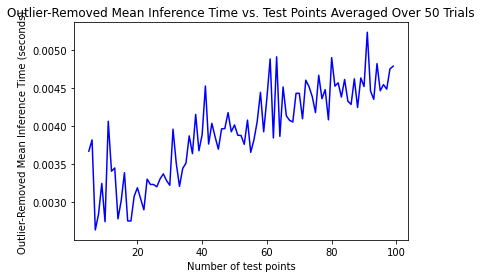

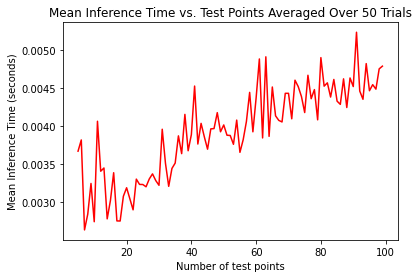

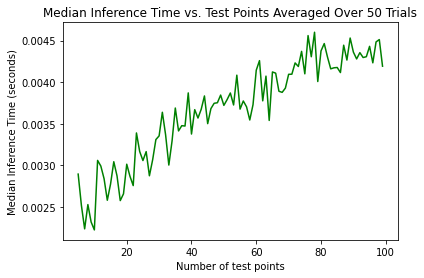

In [21]:
# Plot mean data with outliers removed
plt.plot(point_counts[5:], robust_mean_times[5:], color="b", label="Without outliers")
plt.xlabel("Number of test points")
plt.ylabel("Outlier-Removed Mean Inference Time (seconds)")
plt.title("Outlier-Removed Mean Inference Time vs. Test Points Averaged Over 50 Trials")
plt.show()

# Plot mean data without outlier removal
plt.plot(point_counts[5:], mean_times[5:], color="r", label="With outliers")
plt.xlabel("Number of test points")
plt.ylabel("Mean Inference Time (seconds)")
plt.title("Mean Inference Time vs. Test Points Averaged Over 50 Trials")
plt.show()

# Plot median data
plt.plot(point_counts[5:], median_times[5:], color="g", label="Median times")
plt.xlabel("Number of test points")
plt.ylabel("Median Inference Time (seconds)")
plt.title("Median Inference Time vs. Test Points Averaged Over 50 Trials")
plt.show()